Plot Fig. 2a

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.colors import BoundaryNorm, Normalize

from CP4.utils.make_shapes import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.a1_make_var_field import *
from CP4.make_composites.b1_make_var_field_anomaly import load_composite_mean_ano_field
from CP4.make_composites.significance.b_compute_var_field_significance_merge import load_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [2]:
ds='CP4A'
res=4
var_ref='twb'
var='twb'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.  # km2
max_hw_size=1000000.  # km2
sw=[4., 4.]
tw=[-72, 72]
samtime=[19, 19]
n_days=3
meth='cc3d'
cnty=26
length=25.  # km
pvalue=0.01
regs=['WSahel', 'CSahel', 'ESahel']
flabel='a'

In [8]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

regs_sahel = [reg for reg in regs if 'Sahel' in reg]

ttl = 'Sahel'
var_ = 'Twb'

In [4]:
#~ Get data

out_data = []
out_hclim = []
out_ano = []
out_n_hhee = []

for reg in regs:
    coords = study_regions[reg]
    lat_range = coords[0]
    lon_range = coords[1]
    lat_min = lat_range[0]
    lat_max = lat_range[1]
    lon_min = lon_range[0]
    lon_max = lon_range[1]

    vardata = load_composite_var(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

    varhclim = load_composite_var_clim(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty)

    ds_ano = load_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty)

    out_data.append(vardata)
    out_hclim.append(varhclim)
    out_ano.append(ds_ano)
    out_n_hhee.append(pd.Series(ds_ano.shape[0]))

pvalues = load_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, regs, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty)

In [5]:
#~ Treat data

out_data = np.concatenate(out_data, axis=0)
out_hclim = np.concatenate(out_hclim, axis=0)
out_ano = xr.concat(out_ano, dim='n')
out_n_hhee = pd.concat(out_n_hhee, axis=1)

out_n_hhee.columns = regs
out_n_hhee['Sahel'] = out_n_hhee[regs_sahel].sum(axis=1)

out_n_hhee.drop(regs_sahel, axis=1, inplace=True)

n_hhee = out_hclim.shape[0]

tw_before = tw[1]+samtime[0]
tw_after = tw[1]+samtime[1]

out_hclim_time = out_hclim[:,tw_before:tw_after+1,:,:].mean(axis=1)

out_hclim_mean = np.nanmean(out_hclim_time, axis=0) # mean across events
out_hclim_med = np.nanmedian(out_hclim_time, axis=0) # median across events

var_hhee_ano_mean = np.nanmean(out_ano.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(out_ano.values, axis=0) # median across events

out_hclim_2plot = out_hclim_mean
var_hhee_ano_2plot = var_hhee_ano_mean

out_hclimmean = np.nanmean(out_hclim_2plot)  # spatial mean
out_hclimmed = np.nanmedian(out_hclim_2plot)
varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)


xs = np.linspace(-pvalues.shape[0]/2, pvalues.shape[0]/2, pvalues.shape[0])
ys = np.linspace(-pvalues.shape[1]/2, pvalues.shape[1]/2, pvalues.shape[1])

xc = (xs[-1]-xs[0]) / 2 + xs[0]
yc = (ys[-1]-ys[0]) / 2 + ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / res  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values

disc_mask = np.broadcast_to(distloc <= r, out_ano.shape)
circ_mask = ((r-0.1 <= distloc) & (distloc <= r+0.1))

xscirc = xsm[circ_mask]
yscirc = ysm[circ_mask]

vals_clim_disc = ma.masked_array(out_hclim_time, ~disc_mask)    # mask: True = masked
vals_clim_disc = ma.filled(vals_clim_disc, fill_value=np.nan)
vals_clim_disc_med = np.nanmean(vals_clim_disc, axis=0) # median across events
vals_clim_disc_mean = np.nanmean(vals_clim_disc_med)  # spatial mean

vals_ano_disc = ma.masked_array(out_ano.values, ~disc_mask)
vals_ano_disc = ma.filled(vals_ano_disc, fill_value=np.nan)
vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # median across events
vals_ano_disc_mean = np.nanmean(vals_ano_disc_med)  # spatial mean

pvalues_ = pvalues.where(pvalues > pvalue, np.nan)
pvalues_.values[~np.isnan(pvalues_)] = 1

/tmp/ipykernel_355751/3306796316.py:55: RuntimeWarning: Mean of empty slice
  vals_clim_disc_med = np.nanmean(vals_clim_disc, axis=0) # median across events
/tmp/ipykernel_355751/3306796316.py:60: RuntimeWarning: Mean of empty slice
  vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # median across events


/home/guicha/miniforge3/envs/env1/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/guicha/miniforge3/envs/env1/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


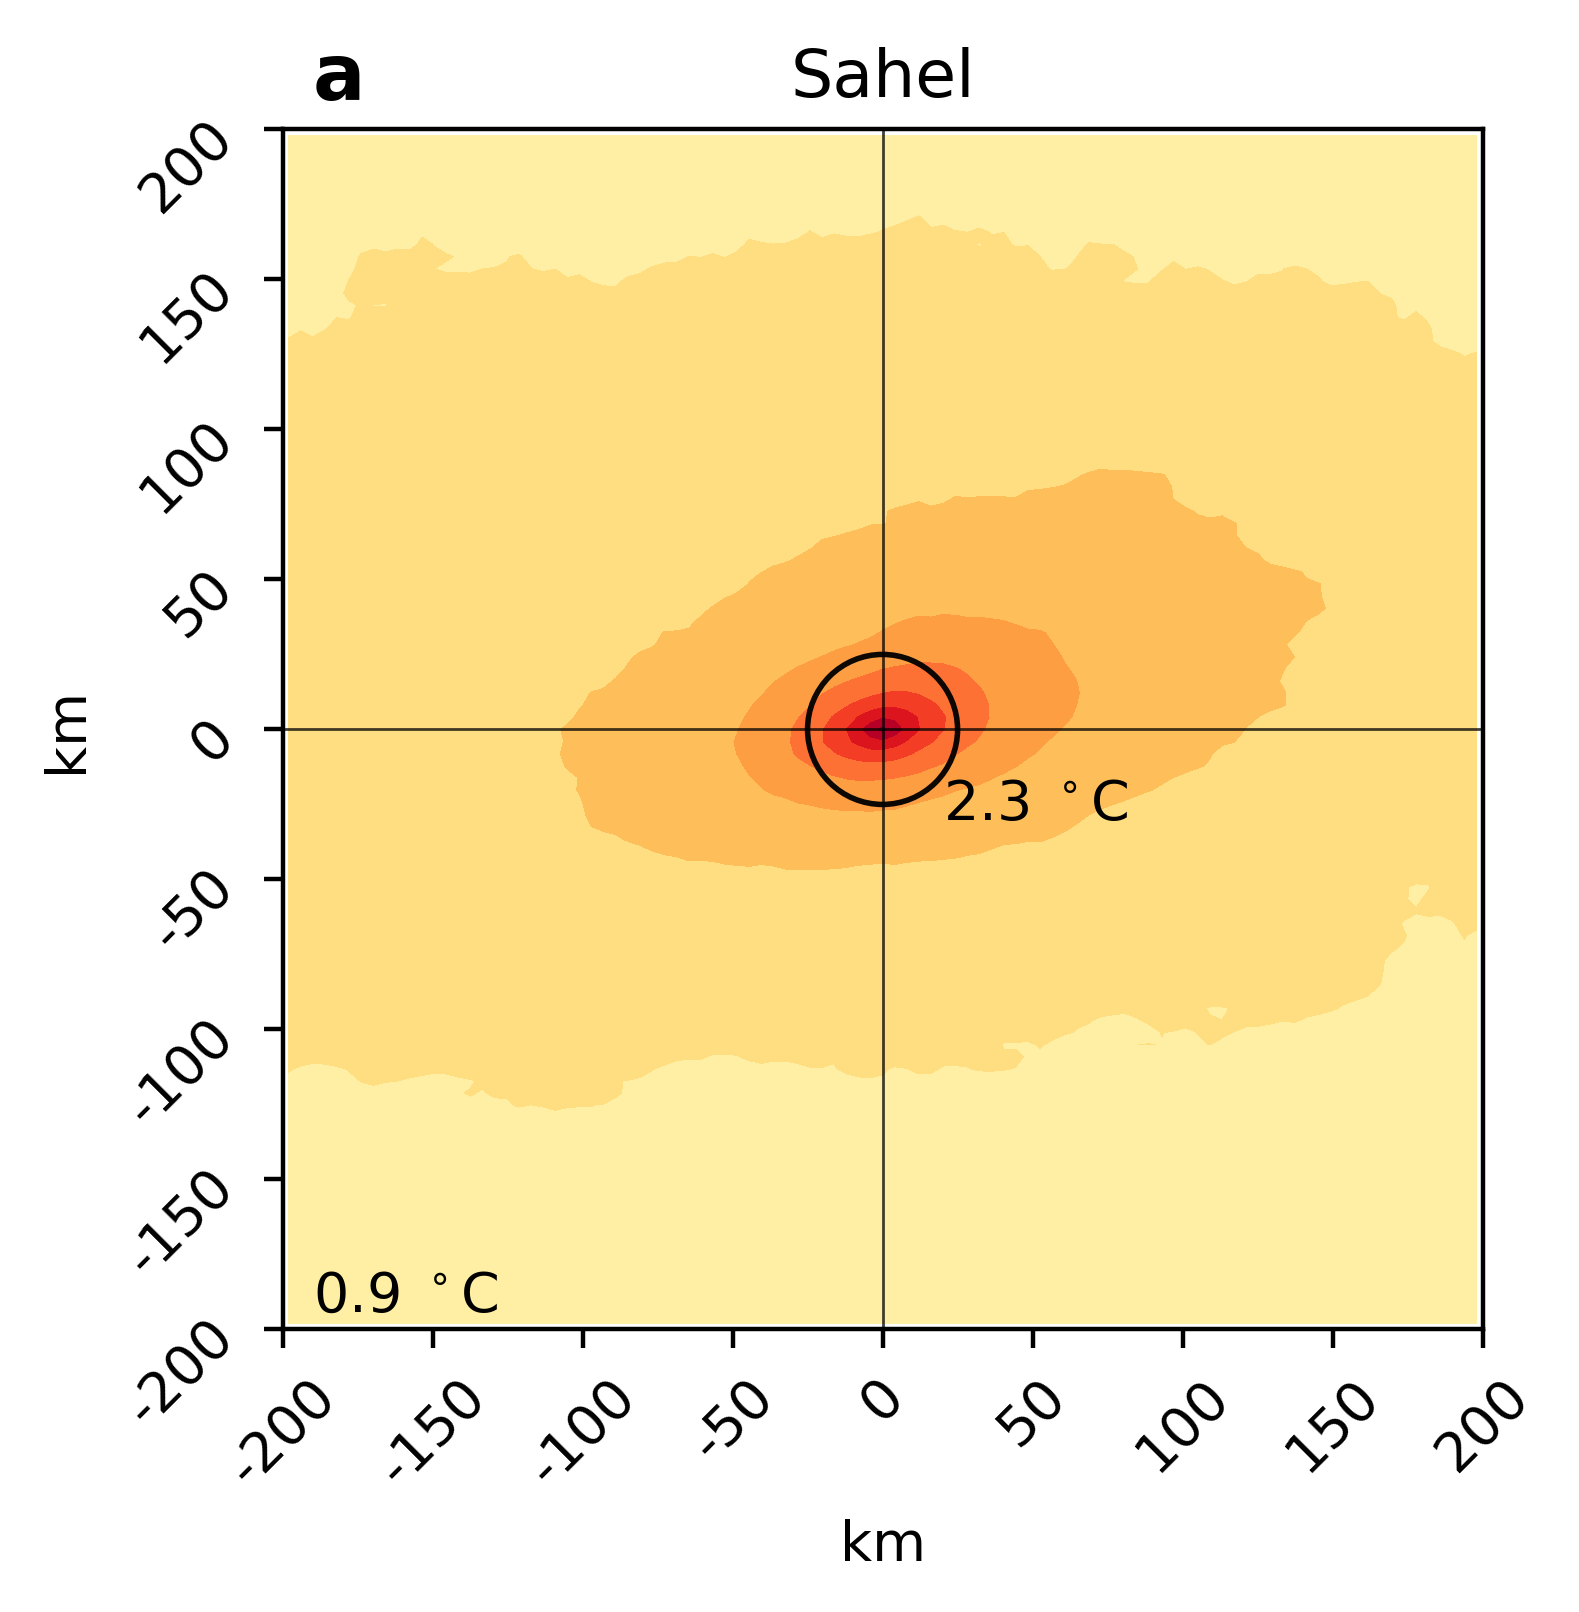

In [6]:
#~ Plot

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor='k', linewidth=1, alpha=0.95)

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / res
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / res

cmap_ano = plt.get_cmap(cmaps['ano'])

anomin = clim_vars_ano[var_ref][var][0]
anomax = clim_vars_ano[var_ref][var][1]

bounds = np.linspace(anomin, anomax, 11)

cmap_ano = plt.get_cmap('YlOrRd')
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap_ano.N)


fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)

p_ano = ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap_ano)

ax_ano.contourf(xs, ys, pvalues_, hatches=['.'], colors='none')

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)
ax_ano.text(0.55, 0.425, '%.1f $^\circ$C'% vals_ano_disc_mean, transform=ax_ano.transAxes)  # (xc)/len(xs)+0.05, (yc-r-2)/l>
ax_ano.text(0.025, 0.015, '%.1f $^\circ$C'% varanomean, transform=ax_ano.transAxes)

ax_ano.add_patch(circle_ano)

ax_ano.axhline(yc, 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline(xc, 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)
ax_ano.set_title(ttl)

fig_ano.set_size_inches(4., 4.)

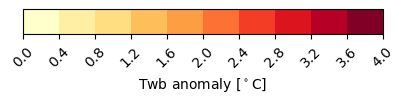

In [9]:
fig_cb_ano, ax_cb_ano = plt.subplots(figsize=(4.5, 1.))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.65, top=0.9)

cbtks = bounds
cblbs = [str(round(b,2)) for b in bounds]

cb_ano = fig_cb_ano.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_ano), cax=ax_cb_ano, orientation='horizontal', label='%s anomaly [$^\circ$C]'%var_, shrink=0.95, pad=0.15)

cb_ano.set_ticks(cbtks)
cb_ano.set_ticklabels(cblbs)
cb_ano.ax.tick_params(labelrotation=45.)